In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use("seaborn-white")

import random
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm import tqdm

from data import PermutedMNIST
from utils import EWC, ewc_train, normal_train, test


In [2]:
epochs = 50
lr = 1e-3
batch_size = 128
sample_size = 200
hidden_size = 200
num_task = 3


In [3]:
class MLP(nn.Module):
    def __init__(self, hidden_size=400):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, 10)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x


In [4]:
def get_permute_mnist():
    train_loader = {}
    test_loader = {}
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx),
                                                     batch_size=batch_size)
        random.shuffle(idx)
    return train_loader, test_loader


train_loader, test_loader = get_permute_mnist()


In [5]:
def standard_process(epochs, use_cuda=True, weight=True):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc = {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, optimizer, train_loader[task]))
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader[sub_task]))
        if task == 0 and weight:
            weight = model.state_dict()
    return loss, acc, weight


def ewc_process(epochs, importance, use_cuda=True, weight=None):
    model = MLP(hidden_size)
    if torch.cuda.is_available() and use_cuda:
        model.cuda()
    optimizer = optim.SGD(params=model.parameters(), lr=lr)

    loss, acc, ewc = {}, {}, {}
    for task in range(num_task):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    loss[task].append(normal_train(model, optimizer, train_loader[task]))
                    acc[task].append(test(model, test_loader[task]))
        else:
            old_tasks = []
            for sub_task in range(task):
                old_tasks = old_tasks + train_loader[sub_task].dataset.get_sample(sample_size)
            old_tasks = random.sample(old_tasks, k=sample_size)
            for _ in tqdm(range(epochs)):
                loss[task].append(ewc_train(model, optimizer, train_loader[task], EWC(model, old_tasks), importance))
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader[sub_task]))

    return loss, acc


In [6]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_task * epochs)), v)
    plt.ylim(0, 1)

In [7]:
loss, acc, weight = standard_process(epochs)

100%|██████████| 50/50 [01:45<00:00,  2.12s/it]


In [11]:
acc

{0: [tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(0),
  tensor(

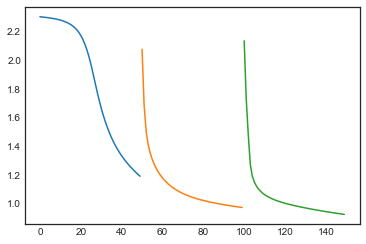

In [8]:
loss_plot(loss)

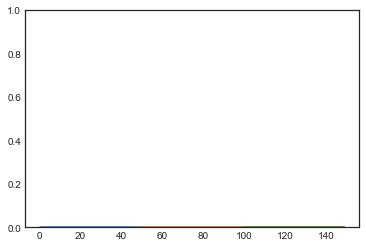

In [10]:
accuracy_plot(acc)

In [10]:
loss_ewc, acc_ewc = ewc_process(epochs, importance=1000, 
#                                 weight=weight
                               )

100%|██████████| 50/50 [02:04<00:00,  2.49s/it]


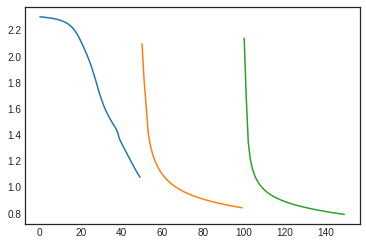

In [11]:
loss_plot(loss_ewc)

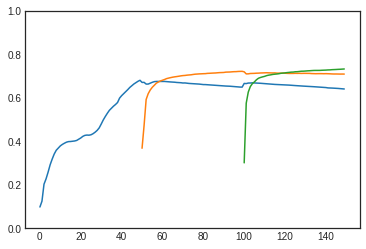

In [12]:
accuracy_plot(acc_ewc)

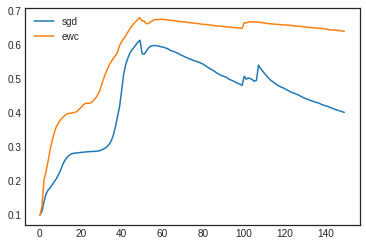

In [13]:
plt.plot(acc[0], label="sgd")
plt.plot(acc_ewc[0], label="ewc")
plt.legend()